In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [45]:
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

In [49]:
pollution_group_dep = pd.read_csv("pollution_group_dep.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [50]:
pop = pd.read_csv('base_pop_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [51]:
pop = pop.drop(['Unnamed: 0'], axis=1)

In [48]:
eff

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,npop,prev,niveau_prioritaire,libelle_classe_age,libelle_sexe,tri
0,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,1.0,971,290.0,4210.0,6.912,"2,3",de 80 à 84 ans,hommes,51.0
1,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,3.0,973,40.0,650.0,5.864,"2,3",de 80 à 84 ans,hommes,51.0
2,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,4.0,999,410.0,5630.0,7.340,"2,3",de 80 à 84 ans,hommes,51.0
3,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,6.0,999,20.0,350.0,4.913,"2,3",de 80 à 84 ans,hommes,51.0
4,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11.0,75,2960.0,20820.0,14.221,"2,3",de 80 à 84 ans,hommes,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036148,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,45-49,1.0,44.0,55,NaN,5390.0,NaN,2,de 45 à 49 ans,hommes,20.0
2036149,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,45-49,1.0,44.0,88,NaN,11930.0,NaN,2,de 45 à 49 ans,hommes,20.0
2036150,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,45-49,1.0,53.0,22,NaN,18390.0,NaN,2,de 45 à 49 ans,hommes,20.0
2036151,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,45-49,1.0,75.0,19,NaN,7380.0,NaN,2,de 45 à 49 ans,hommes,20.0


In [53]:
# Fusion des tables effectifs, pop et pollution_group_dep

merged_df = pd.merge(eff, pollution_group_dep, left_on=['dept'], right_on=['DEP'], 
                    how='inner')
pop_eff_pol = pd.merge(merged_df, pop, left_on=['DEP'], right_on=['numero_dep'], 
                    how='inner')

# Supprimer les colonnes redondantes
pop_eff_pol = pop_eff_pol.drop(['numero_dep', 'dept'], axis=1)

#Pour ne pas confondre les variables DEP (int) et dep (str)
pop_eff_pol = pop_eff_pol.rename(columns={'dep': 'nom_dep'})

In [55]:
pop_eff_pol

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,ntop,npop,...,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire,nom_dep,total_habitants
0,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11.0,2960.0,20820.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
1,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,9.0,11.0,7990.0,50520.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
2,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,90-94,2.0,11.0,1450.0,14960.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
3,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,95et+,2.0,11.0,370.0,7540.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
4,2020,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,tsage,2.0,11.0,41370.0,1119660.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629098,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,10-14,1.0,53.0,NaN,17820.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
1629099,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,15-19,1.0,53.0,NaN,16990.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
1629100,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,15-19,9.0,53.0,NaN,33590.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
1629101,2015,Cancers,Cancer de la prostate,NaN,sup_CanPros_cat,40-44,1.0,53.0,NaN,17780.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834


In [ ]:
#Les données datent de 2015 à 2020, 
#on prend le classement par PIB par habitant par département et on garde 
#le dep avec le PIB par habitant le plus élevé (Paris (75), pib/habitant de 127 132€)
#celui où il est le plus faible (la Creuse (23), pib/habitant de 23 192€),
#et celui qui est le plus près de la moyenne nationale (Bas-Rhin (67)).
#Le PIB moyen par habitant en 2021 est de 37 431€ par an.
# source : wikipedia

In [57]:
pop_eff_pol['nom_dep'].unique()

array(['Paris', 'Val-de-Marne', "Val-d'Oise", 'Doubs', 'Nièvre', 'Eure',
       'Orne', 'Pas-de-Calais', 'Somme', 'Meurthe-et-Moselle', 'Bas-Rhin',
       'Mayenne', 'Gironde', 'Landes', 'Lot-et-Garonne', 'Vienne',
       'Hérault', 'Lot', 'Lozère', 'Hautes-Pyrénées', 'Tarn-et-Garonne',
       'Ariège', 'Ain', 'Puy-de-Dôme', 'Rhône', 'Haute-Savoie',
       'Haute-Corse', 'Essonne', 'Hauts-de-Seine', 'Eure-et-Loir',
       'Indre-et-Loire', 'Loir-et-Cher', 'Loiret', 'Yonne',
       'Territoire de Belfort', 'Calvados', 'Aube', 'Marne',
       'Haute-Marne', 'Moselle', 'Ardennes', 'Maine-et-Loire', 'Sarthe',
       'Vendée', 'Ille-et-Vilaine', 'Morbihan', 'Dordogne',
       'Pyrénées-Atlantiques', 'Aveyron', 'Pyrénées-Orientales', 'Allier',
       'Isère', 'Loire', 'Alpes-Maritimes', 'Vaucluse', 'Yvelines',
       'Cher', "Côte-d'Or", 'Aisne', 'Haut-Rhin', 'Charente-Maritime',
       'Creuse', 'Deux-Sèvres', 'Haute-Vienne', 'Gard', 'Haute-Garonne',
       'Gers', 'Cantal', 'Bouches-du-Rhô

In [70]:
len(pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris') & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')])

218

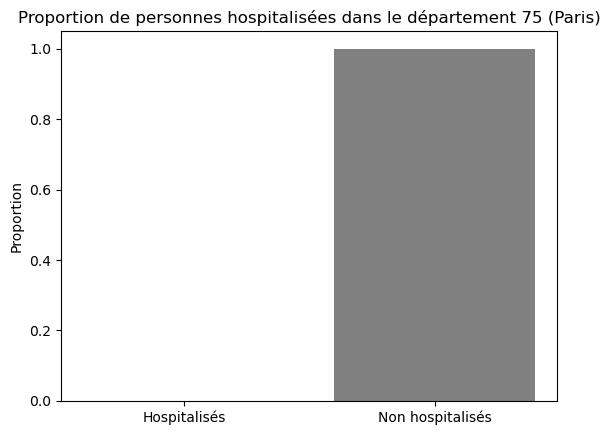

In [64]:
# Filtrer les données pour le département 75 (Paris) et la variable patho_niv1
paris_data = pop_eff_pol[pop_eff_pol['nom_dep'] == 'Paris']
hospitalized_data = paris_data[paris_data['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)']

# Calculer la proportion de personnes hospitalisées
proportion_hospitalized = len(hospitalized_data) / paris_data['total_habitants'].sum()

# Créer un histogramme
labels = ['Hospitalisés', 'Non hospitalisés']
sizes = [proportion_hospitalized, 1 - proportion_hospitalized]

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=['blue', 'gray'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées dans le département 75 (Paris)')

plt.show()

In [ ]:
# On en voit rien vu que la proportion de personnes 
#hospitalisées sur la population parisienne totale est néglgeable
#idée : prendre en compte la variable niveau_prioritaire pour comparer

In [76]:
type(pop_eff_pol['niveau_prioritaire'])

pandas.core.series.Series

In [88]:
pop_eff_pol['niveau_prioritaire'].unique()

array(['2,3', '1', nan, '2', '3'], dtype=object)

In [87]:
pop_eff_pol['niveau_prioritaire'].replace('1,2,3', np.nan, inplace=True)

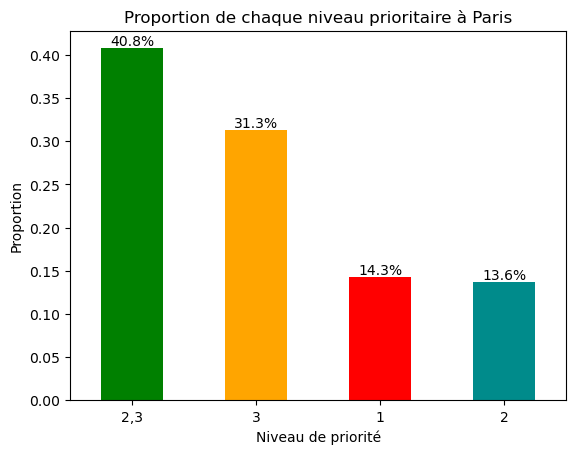

In [94]:
# Filtrer les données pour le département 75 (Paris)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire à Paris')

# Fonction pour ajouter les pourcentages au-dessus des barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height, f'{height:.1%}',
                ha='center', va='bottom')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

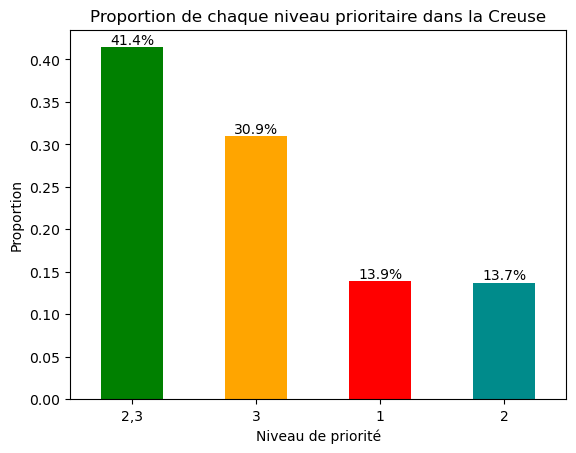

In [95]:
# Filtrer les données pour le département 23 (Creuse)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Creuse')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

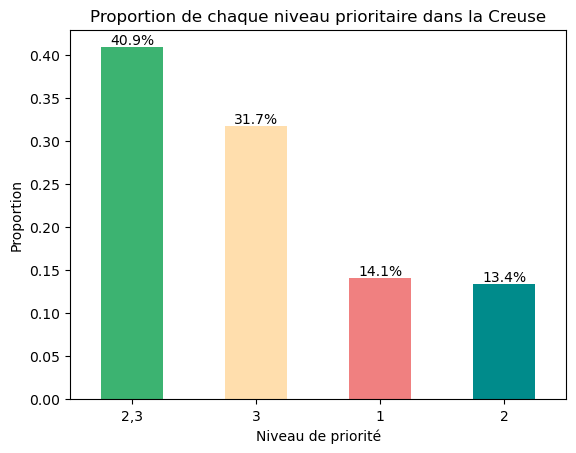

In [109]:
# Filtrer les données pour le département 67 (Bas-Rhin)
paris_data = pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Bas-Rhin')]

# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = paris_data.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['mediumseagreen', 'navajowhite', 'lightcoral', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

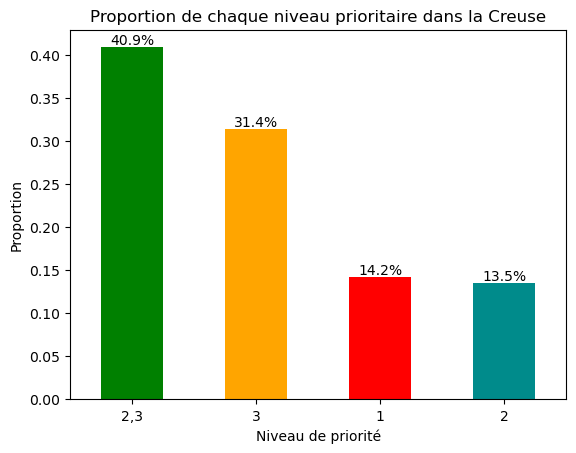

In [96]:
# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
paris_data = pop_eff_pol.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = paris_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['green', 'orange', 'red', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion de chaque niveau prioritaire dans la Creuse')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()